## Спортивный анализ данных. Платформа Kaggle
### Feature Engineering, Feature Selection II

### Практическое задание 5.

Продолжим работу с данными, которые были использованы ранее, возмьмем за основу набор данных с дополнительными признаками, которые были созданы в предыдущем задании (оставить все признаки, вне зависимости от того, добавляют они качества или нет).

* __Задание 0:__ выбрать любимую модель и схему валидации решения, зафиксировать базовое качество модели.

* __Задание 1:__ использовать внутренний способ для оценки важности признаков алгоритма, вывести его в виде диаграммы.

* __Задание 2:__ удалить признаки с нулевой или маленькой важностью, переобучить модель и оценить изменение качества.

* __Задание 3:__ использовать permutation importance, выполнить задание 1 и 2.

* __Задание 4:__ использовать BoostARoota для отбора признаков (настраивать или нет - на ваше усмотрение), переобучить модель и оценить изменение качества.

* __Задание 5:__ использовать shap, выполнить задание 1 и 2.

* __Задание 6:__ построить shap.summary_plot и shap.decision_plot для небольшой группы примеров (определить размер самостоятельно) и проанализировать влияние признаков на поведение модели.

Ссылка на данные - https://drive.google.com/file/d/1GN6d4_QTYWY-qFdjz_TqxFHIJRi_oTRP/view?usp=sharing

In [1]:
import numpy as np
import pandas as pd

from datetime import datetime, timedelta
from time import mktime

import scipy.stats as st
from scipy.stats import probplot, ks_2samp
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_is_fitted

from sklearn.inspection import permutation_importance
from boostaroota import BoostARoota
import shap

import xgboost as xgb
from xgboost.sklearn import XGBClassifier

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')

#### Пути к директориям и файлам

In [3]:
PATH = 'C:/Users/ASER/Desktop/GeekBrains/Kaggle/Lesson_2/data/'
TRAIN_DATASET_PATH = PATH + 'train.csv'
TEST_DATASET_PATH = PATH + 'test.csv'

#### Загрузка данных

In [4]:
train = pd.read_csv(TRAIN_DATASET_PATH)
print('train.shape', train.shape)
train.head(2)

train.shape (180000, 394)


,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
test = pd.read_csv(TEST_DATASET_PATH)
print('test.shape', test.shape)
test.head(2)

test.shape (100001, 394)


,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,3287000,1,7415038,226.0,W,12473,555.0,150.0,visa,226.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3287001,0,7415054,3072.0,W,15651,417.0,150.0,visa,226.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
TARGET_NAME = 'isFraud'

#### Обзор распределения целевой переменной

In [7]:
train[TARGET_NAME].value_counts()

0    174859
1      5141
Name: isFraud, dtype: int64

#### Классификация признаков

In [8]:
INDEPENDENT_VARIABLE_NAMES = train.columns.to_list()[2:]
INDEPENDENT_VARIABLE_NAMES[:3]

['TransactionDT', 'TransactionAmt', 'ProductCD']

In [9]:
NUMERICAL_FEATURE_NAMES = train[INDEPENDENT_VARIABLE_NAMES].select_dtypes(include=[np.number]).columns.to_list()
CATEGORICAL_FEATURE_NAMES = train[INDEPENDENT_VARIABLE_NAMES].select_dtypes(include=[np.object]).columns.to_list()

print(f'count of numerical features {len(NUMERICAL_FEATURE_NAMES)}')
print(f'count of categorical features {len(CATEGORICAL_FEATURE_NAMES)}')

count of numerical features 378
count of categorical features 14


#### Обработка категориальных признаков

In [10]:
class FeatureGenerator:
    def __init__(self, CATEGORICAL_FEATURE_NAMES):
        self.CATEGORICAL_FEATURE_NAMES = CATEGORICAL_FEATURE_NAMES
        self.NEW_CATEGORICAL_FEATURE_NAMES = []
        self.LGB_CATEGORICAL_FEATURE_NAMES = []
        self.target_encodings = dict()
        self.ordinal_encoding = dict()
        
        
    def fit(self, train):
        df = train.copy()
        for feature in self.CATEGORICAL_FEATURE_NAMES: 
            new_feature = feature + '_'
            lgb_feature = feature + 'lgb'
            self.NEW_CATEGORICAL_FEATURE_NAMES.append(new_feature)
            self.LGB_CATEGORICAL_FEATURE_NAMES.append(lgb_feature)            
            self.target_encodings[feature] = {}
            self.ordinal_encoding[feature] = {}
            for ind, level in enumerate(df[feature].unique()):
                level_value = df.loc[df[feature]==level, TARGET_NAME].mean()
                self.target_encodings[feature][level] = level_value
                self.ordinal_encoding[feature][level] = ind
                
                
    def transform(self, df):
        for feature in self.CATEGORICAL_FEATURE_NAMES: 
            for level in self.target_encodings[feature].keys():
                new_feature = feature + '_'
                lgb_feature = feature + 'lgb'
                df.loc[df[feature] == level, new_feature] = self.target_encodings[feature][level]
                df.loc[df[feature] == level, lgb_feature] = self.ordinal_encoding[feature][level]
                
        df[CATEGORICAL_FEATURE_NAMES] = df[CATEGORICAL_FEATURE_NAMES].astype(str)  
        
        return df

#### Train_test_split

In [11]:
df = train.sort_values(by=['TransactionDT'])
df_train = df.loc[:125999, :]
df_valid = df.loc[126000:152999, :]
df_test = df.loc[153000:, :]

#### Генерация признаков

* a) oбучающий датасет + отложеная выборка

In [12]:
features = FeatureGenerator(CATEGORICAL_FEATURE_NAMES)
features.fit(df_train)
df_train = features.transform(df_train)
df_valid = features.transform(df_valid)
df_test = features.transform(df_test)

* b) тестовый датасет

In [13]:
features = FeatureGenerator(CATEGORICAL_FEATURE_NAMES)
features.fit(train)
train = features.transform(train)
test = features.transform(test)

In [14]:
SELECTED_FEATURE_NAMES = NUMERICAL_FEATURE_NAMES + features.NEW_CATEGORICAL_FEATURE_NAMES

### Дополнительные признаки

#### 1. Признак TransactionDT

In [15]:
def transform_TransactionDT(data):
    t = t0 + pd.to_timedelta(data['TransactionDT'], unit='s')
    data.loc[:, 'year'] = t.dt.year
    data.loc[:, 'month'] = t.dt.month
    data.loc[:, 'weekday'] = t.dt.weekday
    data.loc[:, 'hour'] = t.dt.hour
    data.loc[:, 'day'] = t.dt.day 
    
    return data

In [16]:
t0 = datetime.strptime('2017-12-01', "%Y-%m-%d")

df_list = [df_train, df_valid, df_test, test]
for df in df_list:
    df = transform_TransactionDT(df)
    
TIME_FEATURE_NAMES = ['year', 'month', 'weekday', 'hour', 'day']
SELECTED_FEATURE_NAMES.remove('TransactionDT')
SELECTED_FEATURE_NAMES += TIME_FEATURE_NAMES  

#### 2. Соединение признаков
* card1 + card2;

* card1 + card2 + card_3 + card_5;

* card1 + card2 + card_3 + card_5 + addr1 + addr2

In [17]:
def merge_features(data, concat_lists, NEW_FEATURE_NAMES):
    for i, cols in enumerate(concat_lists):
        if i > 0:        
            cols = [NEW_FEATURE_NAMES[i - 1]] + cols
        data.loc[:, NEW_FEATURE_NAMES[i]] = data.loc[:, cols].\
                    apply(lambda x: ''.join(str(x.values))[1:-1].replace("'", ""), axis=1)
    return data

In [18]:
class FrequencyEncoder: 
    def __init__(self, features_list):
        self.features_list = features_list
        self.NEW_FEATURE_NAMES = []
        self.freq = {}
        
        
    def fit_transform(self, data):
        for feature in self.features_list:
            name_str = feature + '_freq'
            self.NEW_FEATURE_NAMES.append(name_str)
            
            self.freq[feature] = data[feature].value_counts() 
            
            for i, value in enumerate(self.freq[feature].keys()):
                data.loc[data[feature] == value, name_str] = self.freq[feature].values[i]               
    
        return data
    
    def transform(self, data):
        for feature in self.features_list:
            name_str = feature + '_freq'
            for i, value in enumerate(self.freq[feature].keys()):                
                data.loc[data[feature] == value, name_str] = self.freq[feature].values[i] 
                
        return data

In [19]:
concat_lists = [['card1', 'card2'], ['card3', 'card5'], ['addr1', 'addr2']]
NEW_FEATURE_NAMES = ['card1_2', 'card1_2_3_5', 'card1_2_3_5_addr1_2']

for df in df_list:
    df = merge_features(df, concat_lists, NEW_FEATURE_NAMES)

In [20]:
freq_encoder = FrequencyEncoder(NEW_FEATURE_NAMES)
df_train = freq_encoder.fit_transform(df_train)
for df in df_list[1:]:
    df = freq_encoder.transform(df)

In [21]:
SELECTED_FEATURE_NAMES += freq_encoder.NEW_FEATURE_NAMES

#### 3. Frequency encoding - признаки card1 - card6, addr1, addr2.

In [22]:
features_list = ['card1', 'card2', 'card3', 'card4', 'card5', 'card6', 'addr1', 'addr2']

freq_encoder = FrequencyEncoder(features_list)
df_train = freq_encoder.fit_transform(df_train)
for df in df_list[1:]:
    df = freq_encoder.transform(df)

In [23]:
SELECTED_FEATURE_NAMES += freq_encoder.NEW_FEATURE_NAMES

#### 4. TransactionAmt

Создать признаки на основе отношения: TransactionAmt к вычисленной статистике. Статистика - среднее значение / стандартное отклонение TransactionAmt, сгруппированное по card1 - card6, addr1, addr2, и по признакам, созданным в задании 2.

In [24]:
class CompositFeatures:
    def __init__(self, base_feature, features_list):
        self.base_feature = base_feature
        self.features_list = features_list
        self.NEW_FEATURE_NAMES = []
        self.stat = {}
        
        
    def fit_transform(self, data):
        for feature in self.features_list:
            df = data[[self.base_feature, feature]]            
            self.stat[feature] = df.groupby(feature).mean() / df.groupby(feature).std()
            
            name_str_1 = 'stat_' + feature
            for i in self.stat[feature].index:            
                df.loc[df[feature] == i, name_str_1] = self.stat[feature].loc[i, base_feature]

            name_str_2 =  base_feature + '_' + name_str_1
            self.NEW_FEATURE_NAMES.append(name_str_2)
            
            data[name_str_2] = df[base_feature] / df[name_str_1]

        return data
    
    
    def transform(self, data):
        for feature in self.features_list:
            df = data[[self.base_feature, feature]]
            
            name_str_1 = 'stat_' + feature
            for i in self.stat[feature].index:            
                    df.loc[df[feature] == i, name_str_1] = self.stat[feature].loc[i, base_feature]
                    
            name_str_2 =  base_feature + '_' + name_str_1            
            data[name_str_2] = df[base_feature] / df[name_str_1]
            
        return data

In [25]:
features_list += ['card1_2', 'card1_2_3_5', 'card1_2_3_5_addr1_2']

In [26]:
base_feature = 'TransactionAmt'
comp_features = CompositFeatures(base_feature, features_list)
df_train = comp_features.fit_transform(df_train)
for df in df_list[1:]:
    df = comp_features.transform(df)

In [27]:
SELECTED_FEATURE_NAMES += comp_features.NEW_FEATURE_NAMES

#### 5. D15
Создать признаки на основе отношения: D15 к вычисленной статистике. Статистика - среднее значение / стандартное отклонение D15, сгруппированное по card1 - card6, addr1, addr2, и по признакам, созданным в задании 2.

In [28]:
base_feature = 'D15'
comp_features = CompositFeatures(base_feature, features_list)
df_train = comp_features.fit_transform(df_train)
for df in df_list[1:]:
    df = comp_features.transform(df)
    
NEW_FEATURES_NAMES = [base_feature + '_stat_' + i for i in features_list]

In [29]:
SELECTED_FEATURE_NAMES += comp_features.NEW_FEATURE_NAMES

#### 6. TransactionAmt - целая и дробная часть, логарифм
Выделить дробную часть и целую часть признака TransactionAmt в два отдельных признака. После создать отдельных признак - логарифм от TransactionAmt

In [30]:
def transform_feature(data, name_str):
    name_1 = name_str + '_int'
    name_2 = name_str + '_frac'
    name_3 = name_str + '_log'
    data[name_1] = data[name_str].astype(int)
    data[name_2] = data[name_str] - data[name_1]
    data[name_3] = np.log(data[name_str])
    
    return data

In [31]:
name_str = 'TransactionAmt'
for df in df_list:
    df = transform_feature(df, name_str)

In [32]:
SELECTED_FEATURE_NAMES.remove('TransactionAmt')
SELECTED_FEATURE_NAMES += ['TransactionAmt_int', 'TransactionAmt_frac', 'TransactionAmt_log']

#### 7. Frequency Encoding P_emaildomain и R_emaildomain
Выполнить предварительную подготовку / очистку признаков P_emaildomain и R_emaildomain (что и как делать - остается на ваше усмотрение) и сделать Frequency Encoding для очищенных признаков.

In [33]:
def classify_email_address(data, features_list, add_email):
    for feature in features_list:
        a = list(data[feature].value_counts().keys())
        gmail = [i for i in a if i[:5]=='gmail']
        yahoo = [i for i in a if i[:5]=='yahoo']
        hotmail = [i for i in a if i[:7]=='hotmail']
        live = [i for i in a if i[:4]=='live']            
        e_mail_list = gmail + yahoo + hotmail + live + add_email
        name_str = feature + '_'
        data.loc[data[feature].isin(e_mail_list), name_str] = 1
        data.loc[data[feature].isnull(), name_str] = -9
        
    return data

In [34]:
features_list = ['P_emaildomain', 'R_emaildomain']
add_email = ['aol.com', 'anonymous.com'] 
for df in df_list:
    df = classify_email_address(df, features_list, add_email)

In [35]:
features_list = ['P_emaildomain_', 'R_emaildomain_']

freq_encoder = FrequencyEncoder(features_list)
df_train = freq_encoder.fit_transform(df_train)
for df in df_list[1:]:
    df = freq_encoder.transform(df)

In [36]:
SELECTED_FEATURE_NAMES += freq_encoder.NEW_FEATURE_NAMES

### Сохранение и загрузка обработанных данных:

In [15]:
pkl_names = ['df_train.pkl', 'df_valid.pkl', 'df_test.pkl', 'test.pkl']
def save_datasets():
    for i, db in enumerate(df_list):
        db.to_pickle(PATH + pkl_names[i])
        
def load_dataset(SELECTED_FEATURE_NAMES):
    df_train = pd.read_pickle(PATH + 'df_train.pkl')
    df_valid = pd.read_pickle(PATH + 'df_valid.pkl')
    df_test = pd.read_pickle(PATH + 'df_test.pkl')
    test = pd.read_pickle(PATH + 'test.pkl')
    
    SELECTED_FEATURE_NAMES += df_train.columns[-46:].tolist()
    to_remove_list = ['TransactionDT', 'TransactionAmt', 
                      'card1_2', 'card1_2_3_5', 'card1_2_3_5_addr1_2']
    SELECTED_FEATURE_NAMES = [i for i in SELECTED_FEATURE_NAMES if i not in to_remove_list]
    
    return df_train, df_valid, df_test, test, SELECTED_FEATURE_NAMES

In [16]:
#save_datasets()

In [17]:
df_train, df_valid, df_test, test, SELECTED_FEATURE_NAMES = load_dataset(SELECTED_FEATURE_NAMES)

### Модель

In [18]:
params_xgb = {"booster": "gbtree", 
              "objective": "binary:logistic", 
              "eval_metric": "auc", 
              "learning_rate": 0.2,               
              "reg_lambda": 100, 
              "max_depth": 4, 
              "gamma": 10, 
              "nthread": 6, 
              "seed": 27}

In [19]:
def run_model(SELECTED_FEATURE_NAMES):
    dtrain = xgb.DMatrix(data=df_train[SELECTED_FEATURE_NAMES], label=df_train[TARGET_NAME])
    dvalid = xgb.DMatrix(data=df_valid[SELECTED_FEATURE_NAMES], label=df_valid[TARGET_NAME])
    dtest = xgb.DMatrix(data=df_test[SELECTED_FEATURE_NAMES], label=df_test[TARGET_NAME])

    model_xgb = xgb.train(params=params_xgb,
                          dtrain=dtrain,
                          num_boost_round=1000,
                          early_stopping_rounds=50,
                          evals=[(dtrain, "train"), (dvalid, "valid"), (dtest, "test")],
                          verbose_eval=50,
                          maximize=True)

    dtest_final = xgb.DMatrix(data=test[SELECTED_FEATURE_NAMES])

    y_pred = model_xgb.predict(dtest_final, ntree_limit=model_xgb.best_ntree_limit)
    score = roc_auc_score(test[TARGET_NAME], y_pred)
    print(f'roc-auc score of prediction: {round(score, 5)}')
    return model_xgb

#### 0. Базовая модель

In [20]:
model_xgb = run_model(SELECTED_FEATURE_NAMES)

[0]	train-auc:0.60237	valid-auc:0.61788	test-auc:0.62471
Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 50 rounds.
[50]	train-auc:0.91051	valid-auc:0.88766	test-auc:0.86895
[100]	train-auc:0.91771	valid-auc:0.89242	test-auc:0.87688
Stopping. Best iteration:
[72]	train-auc:0.91753	valid-auc:0.89265	test-auc:0.87711

roc-auc score of prediction: 0.8654


#### 1. Диаграмма оценки важности признаков алгоритма (внутренний способ)

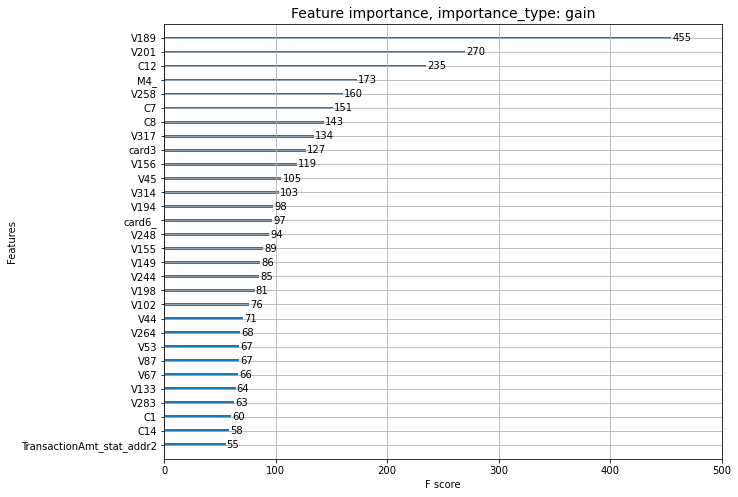

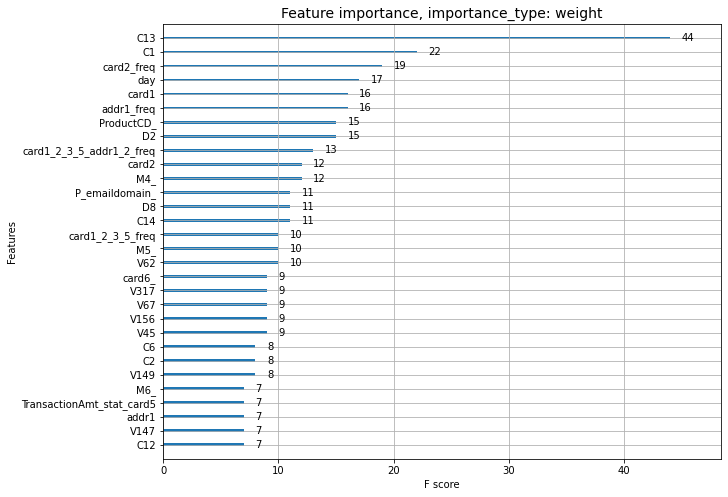

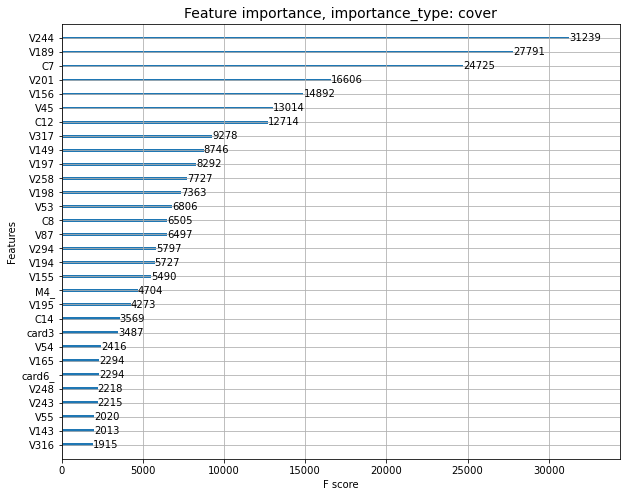

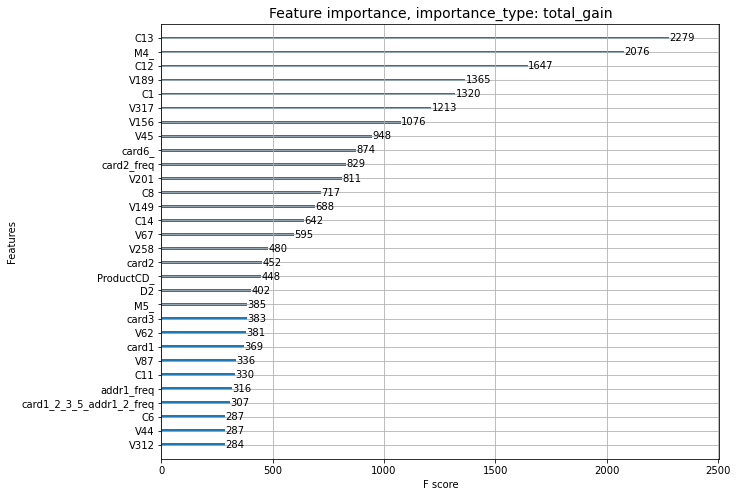

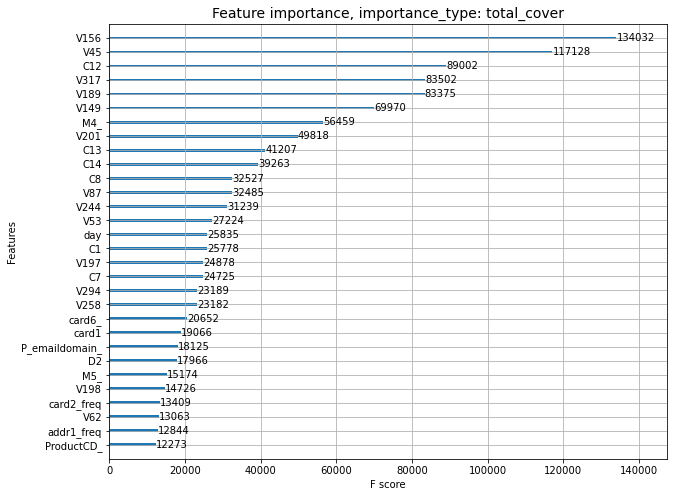

In [21]:
importance_type = ['gain', 'weight', 'cover', 'total_gain', 'total_cover']
for type_ in importance_type:
    fig, ax = plt.subplots(1, 1, figsize=(10, 8))
    
    importance = model_xgb.get_score(importance_type=type_)
    for key in importance.keys():
        importance[key] = int(importance[key])

    xgb.plot_importance(importance, max_num_features=30, ax=ax)   
    plt.title(f'Feature importance, importance_type: {type_}', size=14)
    plt.show()

#### 2: Модель без признаков с нулевой или маленькой важностью.

In [22]:
n = 50
for type_ in importance_type:
    print(f'importance_type: {type_}')
    importance = model_xgb.get_score(importance_type=type_)
    importance_ = pd.DataFrame.from_dict(importance, orient='index', columns=['score'])
    drop_list = importance_.sort_values(by='score')[:n].index.tolist()
    
    features = list(set(SELECTED_FEATURE_NAMES) - set(drop_list))
    
    run_model(features)
    print('\n')
    
# 'gain' train-auc:0.91357 valid-auc:0.88935 test-auc:0.86814
# roc-auc score of prediction: 0.86776

importance_type: gain
[0]	train-auc:0.60237	valid-auc:0.61787	test-auc:0.62465
Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 50 rounds.
[50]	train-auc:0.90962	valid-auc:0.88615	test-auc:0.86470
[100]	train-auc:0.91357	valid-auc:0.88935	test-auc:0.86814
Stopping. Best iteration:
[68]	train-auc:0.91357	valid-auc:0.88935	test-auc:0.86814

roc-auc score of prediction: 0.86776


importance_type: weight
[0]	train-auc:0.60069	valid-auc:0.61539	test-auc:0.62340
Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 50 rounds.
[50]	train-auc:0.91085	valid-auc:0.89001	test-auc:0.86829
[100]	train-auc:0.91709	valid-auc:0.89448	test-auc:0.87445
Stopping. Best iteration:
[73]	train-auc:0.91709	valid-auc:0.89448	test-auc:0.87445

roc-auc score of prediction: 0.86589


importance_type: cover
[0]	train-auc:0.60236	valid-auc:0.61789	test-auc:0.62

__Вывод:__ Качество модели на тестовой выборке улучшается, если не использовать 50 наименее значимых признаков, отобранных при importance_type='gain'

#### 3. permutation importance

In [23]:
model = XGBClassifier(params=params_xgb, n_estimators=72)
model.fit(df_train[SELECTED_FEATURE_NAMES], df_train[TARGET_NAME])

[20:34:53] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { params } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=72, n_jobs=0, num_parallel_tree=1,
              params={'booster': 'gbtree', 'eval_metric': 'auc', 'gamma': 10,
                      'learning_rate': 0.2, 'max_depth': 4, 'nthread': 6,
                      'objective': 'binary:logistic', 'reg_lambda': 100,
                      'seed': 27},
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [24]:
importance = permutation_importance(model,
                                    df_valid[SELECTED_FEATURE_NAMES], 
                                    df_valid[TARGET_NAME],
                                    scoring="roc_auc",
                                    n_jobs=6, 
                                    random_state=27)

In [25]:
importance_scores = pd.DataFrame({"features": SELECTED_FEATURE_NAMES,
                                  "importance-mean": importance.importances_mean})
importance_scores = importance_scores.sort_values(by="importance-mean", ascending=False)

features = importance_scores.loc[importance_scores["importance-mean"] > 0, 'features'].tolist()
run_model(features)

[0]	train-auc:0.59423	valid-auc:0.61025	test-auc:0.61548
Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 50 rounds.
[50]	train-auc:0.90931	valid-auc:0.88742	test-auc:0.86675
[100]	train-auc:0.91604	valid-auc:0.89256	test-auc:0.87357
Stopping. Best iteration:
[73]	train-auc:0.91557	valid-auc:0.89244	test-auc:0.87390

roc-auc score of prediction: 0.86857


__Вывод:__ Качество модели на тестовой выборке при отборе признаков методом permutation_importance улучшилось в большей степени, чем при отборе внутренним способом Feature importance

#### 4. BoostARoota

In [26]:
br = BoostARoota(metric='auc')
br.fit(df_train[SELECTED_FEATURE_NAMES], df_train[TARGET_NAME])

[20:58:11] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Round:  1  iteration:  1
[21:07:21] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Round:  1  iteration:  2
[21:13:49] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to som

Round:  3  iteration:  1
[21:48:00] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Round:  3  iteration:  2
[21:48:31] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Round:  3  iteration:  3
[21:49:04] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { silent } might not be used.

  This may n

In [27]:
featues = br.keep_vars_.tolist()
len(featues)

233

In [28]:
run_model(features)

[0]	train-auc:0.59423	valid-auc:0.61025	test-auc:0.61548
Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 50 rounds.
[50]	train-auc:0.90931	valid-auc:0.88742	test-auc:0.86675
[100]	train-auc:0.91604	valid-auc:0.89256	test-auc:0.87357
Stopping. Best iteration:
[73]	train-auc:0.91557	valid-auc:0.89244	test-auc:0.87390

roc-auc score of prediction: 0.86857


__Вывод:__ При отборе признаков методом BoostARoota число признаков сократилось почти вдвое, но качество модели на тестовой выборке по сравнению с базовой моделью не улучшилось.

#### 5. Shap

In [29]:
explainer = shap.TreeExplainer(model_xgb)
shap_values = explainer.shap_values(df_valid[SELECTED_FEATURE_NAMES], df_valid[TARGET_NAME])

In [30]:
shap_importances = pd.DataFrame(shap_values.mean(axis=0), SELECTED_FEATURE_NAMES, columns=['shap_values'])
shap_importances.loc[:, 'abs_shap_values'] = abs(shap_importances['shap_values'])
shap_importances = shap_importances.sort_values(by='abs_shap_values', ascending=False)

features = shap_importances[shap_importances['abs_shap_values'] > 0.001].index.tolist()
len(features)

96

In [31]:
run_model(features)
# abs_shap_values > 0.001 roc-auc score of prediction: 0.86756

[0]	train-auc:0.62422	valid-auc:0.61813	test-auc:0.60999
Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 50 rounds.
[50]	train-auc:0.90973	valid-auc:0.88769	test-auc:0.86605
[100]	train-auc:0.91639	valid-auc:0.89359	test-auc:0.87221
Stopping. Best iteration:
[76]	train-auc:0.91639	valid-auc:0.89359	test-auc:0.87221

roc-auc score of prediction: 0.86756


__Выводы:__ 96 признаков, отобранных через shap_values, дают лучший результат по сравнению с базовой моделью на 432 признаках

### 6 shap.summary_plot, shap.decision_plot  
#### shap.summary_plot

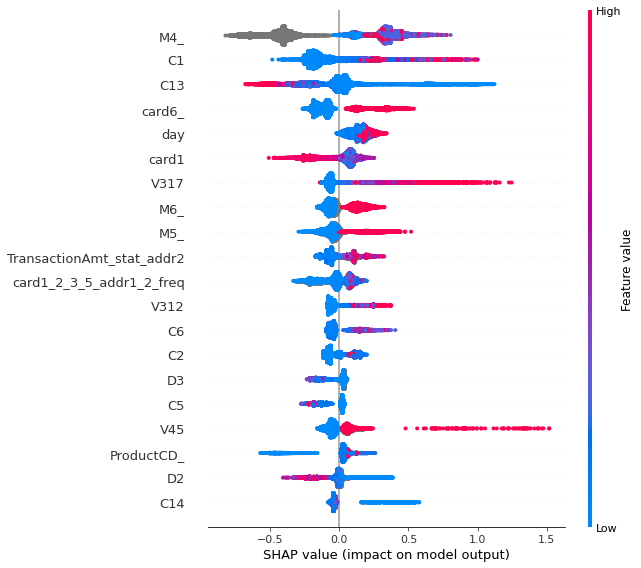

In [32]:
shap.summary_plot(shap_values, df_valid[SELECTED_FEATURE_NAMES])

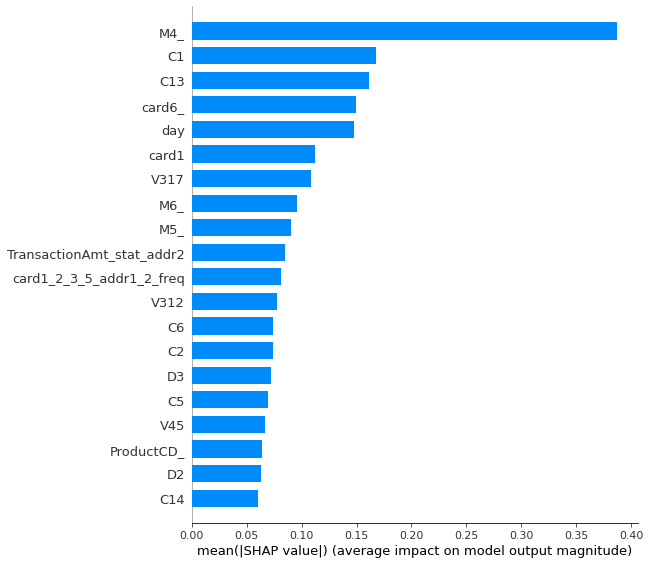

In [33]:
shap.summary_plot(shap_values, df_valid[SELECTED_FEATURE_NAMES], plot_type='bar')

#### shap.decision_plot  

https://slundberg.github.io/shap/notebooks/plots/decision_plot.html

In [37]:
expected_value = explainer.expected_value
if isinstance(expected_value, list):
    expected_value = expected_value[1]
print(f"Explainer expected value: {expected_value}")

n_features = 20
n_pos = 3
ind_1 = df_valid.loc[df_valid[TARGET_NAME] == 1, :].index.tolist()[: n_pos]
ind_0 = df_valid.loc[df_valid[TARGET_NAME] == 0, :].index.tolist()[: n_features - n_pos]

select = ind_0 + ind_1
features = df_valid.loc[select, SELECTED_FEATURE_NAMES]
features_display = features

shap_values = explainer.shap_values(features)
shap_interaction_values = explainer.shap_interaction_values(features)

if isinstance(shap_interaction_values, list):
    shap_interaction_values = shap_interaction_values[1]

Explainer expected value: -3.8940038681030273


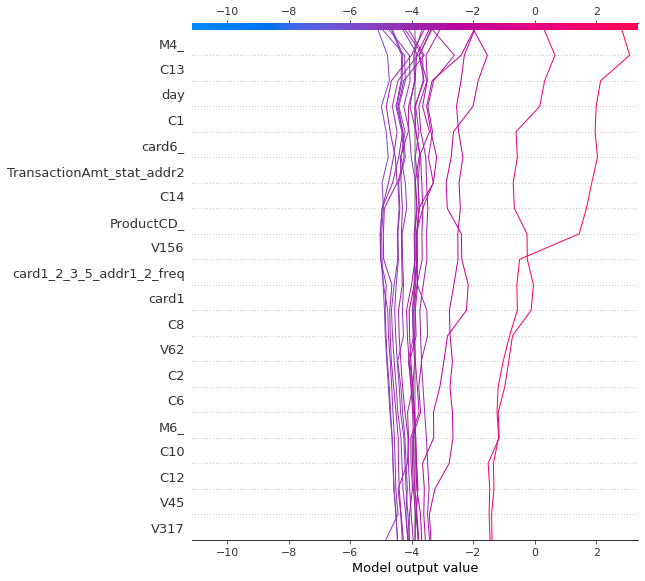

In [38]:
shap.decision_plot(expected_value, shap_values, features_display)

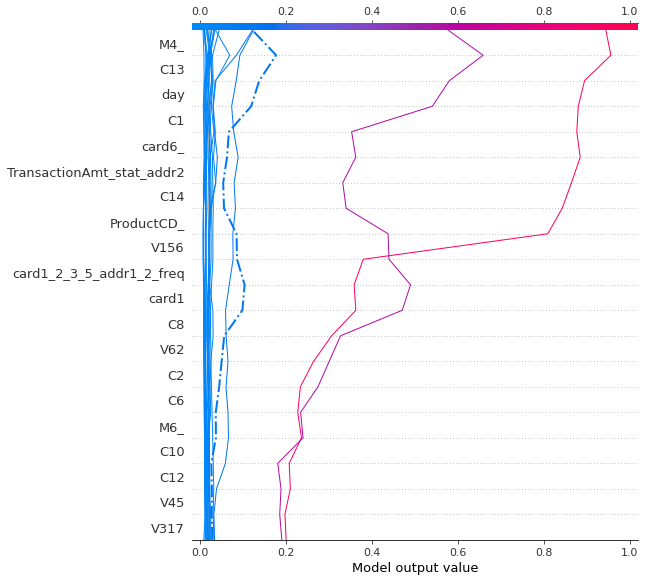

In [39]:
# Our naive cutoff point is zero log odds (probability 0.5).
y_pred = (shap_values.sum(1) + expected_value) > 0
misclassified = y_pred != df_valid.loc[select, TARGET_NAME].values
shap.decision_plot(expected_value, shap_values, features_display, link='logit', highlight=misclassified)

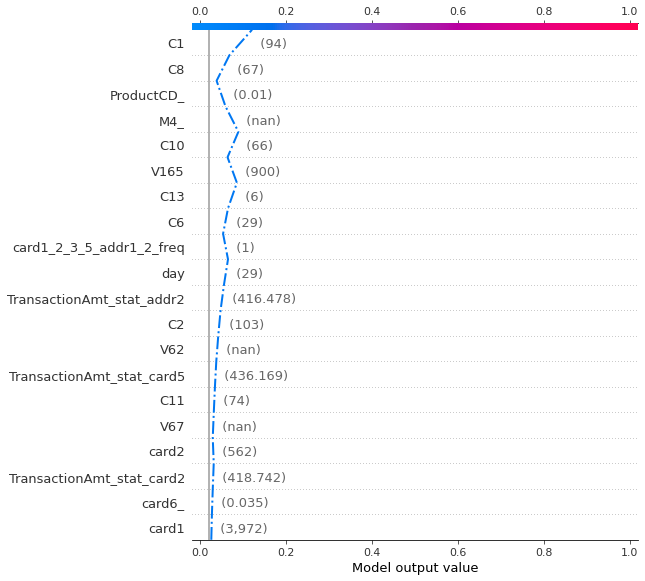

In [40]:
shap.decision_plot(expected_value, shap_values[misclassified], features_display[misclassified],
                   link='logit', highlight=0)

__Выводы:__ По оси y признаки расположены в порядке убывания значимости для отобранных 20 примеров. Для отобранных 20 примеров наиболее значимыми признаками являются: М4_, С13, day, C1, card6 - почти те же, что и у всей валидационнй выборки. При этом у  неверно классифицированного объекта (последний график) признак М4_ пропущен, а из 5 наиболее значимых признаков присутствует только С1, что также является аргументом в пользу 5 наиболее значимых признаков.